# Layerwise Proxy Analysis

Purpose: select a model by GT rank (top or bottom) under a given task/search space, then compute per-layer FLOPs, SWAP, NASWOT, ZiCo-like grad ratio, and visualize. Text in charts is English; code comments in Chinese.

Steps:
1. Configure task/search space and rank (top-k or bottom-k).
2. Load TransNASBench API, sort architectures by GT, pick target.
3. Build model, run a small batch to collect per-layer metrics.
4. Plot per-layer metrics.

> Note: Layerwise ZiCo here uses per-layer mean(NSR) from a single backward pass; layerwise NASWOT uses per-ReLU logdet; SWAP counts unique sign patterns per layer; FLOPs uses fvcore by-module stats.


In [1]:
import sys
from pathlib import Path
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict


# 项目路径（notebook 下用 cwd）
CURRENT_DIR = Path.cwd()
ROOT_DIR = CURRENT_DIR.parent
NASLIB_ROOT = ROOT_DIR / "NASLib"

sys.path.insert(0, str(ROOT_DIR))
sys.path.insert(0, str(NASLIB_ROOT))

# 忽略冗余警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*unsupported.*")
warnings.filterwarnings("ignore", message=".*Unsupported.*")

from proxy_TransNAS.utils.load_model import (
    load_transbench_classes,
    load_transbench_api,
    make_train_loader,
    truncate_loader,
    set_op_indices_from_str,
    get_metric_name,
)
from proxy_TransNAS.proxies.flops import compute_flops  # 全局 FLOPs
from proxy_TransNAS.proxies.naswot import compute_naswot_score, network_weight_gaussian_init  # 全局 NASWOT
from proxy_TransNAS.proxies.swap import compute_swap_score  # 全局 SWAP
from proxy_TransNAS.proxies.zico import compute_zico_score, getgrad_safe  # 全局 ZiCo 与梯度收集
from fvcore.nn import FlopCountAnalysis  # 逐层 FLOPs



In [2]:
# 配置区域（根据需要修改）
TASK = "autoencoder"          # autoencoder / segmentsemantic / normal
SEARCH_SPACE = "macro"        # micro / macro
ARCH_STR = "64-33411-basic"                # 手动指定起始架构（如 "64-33114-basic"）；None 时从 FLOPs 最小开始
ARCH_COUNT = 3                 # 从起始架构起，按 FLOPs 排序取多少个
CSV_PATH = ROOT_DIR / "proxy_TransNAS" / "flops_lookup" / f"flops_{SEARCH_SPACE}_{TASK}.csv"
DATA_ROOT = NASLIB_ROOT / "naslib" / "data"  # 数据根
BATCH_SIZE = 8                 # DataLoader batch，越小越省显存
MAXBATCH = 2                   # 只取前几个 batch
SEED = 42                      # 随机种子
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ENCODER_DECODER_SPLIT = None   # 手动指定分界层索引；None 时自动按层名包含"decoder"检测



In [3]:
# 准备数据与 API
torch.manual_seed(SEED)
TransMicro, TransMacro, graph_module = load_transbench_classes()
Metric = graph_module.Metric

data_root = Path(DATA_ROOT).resolve()
dataset_api = load_transbench_api(data_root, TASK)
api = dataset_api["api"]

# 选择搜索空间实例
target_ss_list = api.all_arch_dict[SEARCH_SPACE]
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransMicro(dataset=TASK, create_graph=True)
else:
    ss = TransMacro(dataset=TASK, create_graph=True)

# 读取 FLOPs CSV，按 flops 升序
csv_path = Path(CSV_PATH).resolve()
assert csv_path.exists(), f"CSV 不存在: {csv_path}"
flookup = pd.read_csv(csv_path)
flookup = flookup.sort_values(by="flops").reset_index(drop=True)

if ARCH_STR is None:
    start_idx = 0
else:
    hit = flookup.index[flookup["arch_str"] == ARCH_STR].tolist()
    assert len(hit) > 0, f"ARCH_STR 未在 CSV 中找到: {ARCH_STR}"
    start_idx = hit[0]

arch_slice = flookup.iloc[start_idx:start_idx + ARCH_COUNT].copy()
print(f"选取区间: [{start_idx}, {start_idx + len(arch_slice)}) / {len(flookup)}")
print(arch_slice[["arch_str", "flops", "gt"]])



选取区间: [304, 307) / 3256
           arch_str         flops        gt
304  64-33411-basic  1.995227e+09  0.492949
305  64-33141-basic  1.995293e+09  0.523561
306  64-33114-basic  1.995358e+09  0.537789


In [4]:
# 构建 DataLoader（仅取少量 batch 以控制显存）
train_loader = make_train_loader(TASK, data_root, BATCH_SIZE, SEED)
train_batches = truncate_loader(train_loader, MAXBATCH)
assert len(train_batches) > 0, "DataLoader is empty"
inputs, labels = train_batches[0]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

# 辅助函数：根据指定架构字符串重新构建模型

def build_model_for_arch(arch_str):  # 每次新建，避免权重被前一步修改
    g = ss.clone()
    g = set_op_indices_from_str(SEARCH_SPACE, g, arch_str)
    g.parse()
    return g.to(DEVICE)



In [5]:
# # 全局 proxy 分数（与运行脚本一致的实现）
# # 每个 proxy 单独构建模型，避免权重修改互相影响

# global_scores = {}

# # FLOPs
# m_flops = build_model()
# global_scores["FLOPs"] = compute_flops(m_flops, train_batches, DEVICE)
# del m_flops; torch.cuda.empty_cache()

# # NASWOT
# m_naswot = build_model()
# global_scores["NASWOT"] = compute_naswot_score(m_naswot, train_batches, DEVICE)
# del m_naswot; torch.cuda.empty_cache()

# # SWAP
# m_swap = build_model()
# global_scores["SWAP"] = compute_swap_score(m_swap, train_batches, DEVICE)
# del m_swap; torch.cuda.empty_cache()

# # ZiCo
# m_zico = build_model()
# loss_fn = torch.nn.L1Loss() if TASK in ["autoencoder", "normal"] else (
#     torch.nn.CrossEntropyLoss()
# )
# global_scores["ZiCo"] = compute_zico_score(m_zico, train_batches, loss_fn, DEVICE)
# del m_zico; torch.cuda.empty_cache()

# global_scores


In [6]:
import numpy.linalg as LA

# 计算单个架构的逐层 proxies（FLOPs/NASWOT/SWAP/ZiCo），返回合并后的 DataFrame

def layer_sort_key(name: str):
    s = str(name)
    if "encoder" in s:
        return (0, s)
    if "decoder" in s:
        return (2, s)
    return (1, s)

def compute_layerwise_proxies(arch_str, batches):
    inputs, labels = batches[0]
    inputs = inputs.to(DEVICE)

    # FLOPs by_module
    model_layer = build_model_for_arch(arch_str)
    model_layer.eval()
    with torch.no_grad():
        flop_analyzer = FlopCountAnalysis(model_layer, inputs[:1])
        flop_analyzer.unsupported_ops_warnings(False)
        flop_analyzer.uncalled_modules_warnings(False)
        by_module = flop_analyzer.by_module()
    flops_df = pd.DataFrame(list(by_module.items()), columns=["layer", "flops"])
    del model_layer; torch.cuda.empty_cache()

    # NASWOT per ReLU
    model_nw = build_model_for_arch(arch_str)
    model_nw.eval()
    network_weight_gaussian_init(model_nw)
    naswot_records = []
    def make_hook(name):
        def hook(module, inp, out):
            x = inp[0].view(inp[0].size(0), -1)
            s = (x > 0).float().cpu().numpy()
            K = s @ s.T + (1 - s) @ (1 - s.T)
            try:
                _, ld = LA.slogdet(K)
                naswot_records.append((name, float(ld)))
            except Exception:
                naswot_records.append((name, float("nan")))
        return hook
    handles = [m.register_forward_hook(make_hook(n))
               for n, m in model_nw.named_modules()
               if isinstance(m, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU))]
    with torch.no_grad():
        _ = model_nw(inputs)
    for h in handles: h.remove()
    del model_nw; torch.cuda.empty_cache()
    naswot_df = pd.DataFrame(naswot_records, columns=["layer", "naswot_logdet"])

    # SWAP per ReLU（与 swap.py 一致：按神经元模式计数）
    model_sw = build_model_for_arch(arch_str)
    model_sw.eval()
    swap_records = []
    def make_swap_hook(name):
        def hook(module, inp, out):
            x = out.view(out.size(0), -1)
            sign = torch.sign(x).cpu().t()  # (neurons, batch)
            unique_rows = torch.unique(sign, dim=0).shape[0]
            swap_records.append((name, int(unique_rows)))
        return hook
    handles = [m.register_forward_hook(make_swap_hook(n))
               for n, m in model_sw.named_modules()
               if isinstance(m, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU))]
    with torch.no_grad():
        _ = model_sw(inputs)
    for h in handles: h.remove()
    del model_sw; torch.cuda.empty_cache()
    swap_df = pd.DataFrame(swap_records, columns=["layer", "swap_unique"])

    # ZiCo per layer
    model_zc = build_model_for_arch(arch_str)
    model_zc.train()
    if TASK in ["autoencoder", "normal"]:
        loss_fn = torch.nn.L1Loss()
    elif TASK == "segmentsemantic":
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    grad_dict = {}
    for step_i, (xb, yb) in enumerate(batches):
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        model_zc.zero_grad()
        logits = model_zc(xb)
        yb_ce = yb.squeeze(1) if (yb.ndim == 4 and yb.shape[1] == 1) else yb
        loss = loss_fn(logits, yb_ce)
        loss.backward()
        grad_dict = getgrad_safe(model_zc, grad_dict, step_i)
        model_zc.zero_grad(set_to_none=True)

    zico_records = []
    for name, grads in grad_dict.items():
        arr = np.array(grads)
        grad_std = np.std(arr, axis=0)
        nz = np.nonzero(grad_std)[0]
        if len(nz) == 0:
            zico_records.append((name, np.nan)); continue
        grad_mean_abs = np.mean(np.abs(arr), axis=0)
        tmpsum = np.mean(grad_mean_abs[nz] / grad_std[nz])
        zico_records.append((name, float(np.log(tmpsum)) if tmpsum > 0 else np.nan))

    del model_zc; torch.cuda.empty_cache()
    zico_df = pd.DataFrame(zico_records, columns=["layer", "zico_log_nsr"])

    # 合并并排序
    merged = flops_df.merge(naswot_df, on="layer", how="outer")
    merged = merged.merge(swap_df, on="layer", how="outer")
    merged = merged.merge(zico_df, on="layer", how="outer")
    merged = merged.fillna(0)
    merged = merged.assign(_order=merged["layer"].apply(layer_sort_key))
    merged = merged.sort_values(by="_order").drop(columns=["_order"]).reset_index(drop=True)
    return merged


In [7]:
# 批处理所选架构：仅逐层 proxies（不计算全局 proxy）
results = []  # 每个元素: {arch_str, flops, gt, merged}
for _, row in arch_slice.iterrows():
    arch = row["arch_str"]
    flp = row["flops"]
    gt = row["gt"]
    merged = compute_layerwise_proxies(arch, train_batches)
    results.append({"arch_str": arch, "flops": flp, "gt": gt, "merged": merged})
    print(f"done: {arch}, flops={flp:.1f}, gt={gt:.4f}")


done: 64-33411-basic, flops=1995227136.0, gt=0.4929
done: 64-33141-basic, flops=1995292672.0, gt=0.5236
done: 64-33114-basic, flops=1995358208.0, gt=0.5378


In [8]:
# 调试：查看合并后的层名和分界（使用首个架构）
if len(results) > 0:
    merged_preview = results[0]["merged"].reset_index(drop=True)
    decoder_mask = merged_preview["layer"].astype(str).str.contains("decoder", case=False, na=False)
    first_decoder_idx = int(decoder_mask.idxmax()) if decoder_mask.any() else None
    print("Total layers (first arch):", len(merged_preview))
    print("First decoder idx:", first_decoder_idx)
    if first_decoder_idx is not None:
        print(merged_preview.loc[first_decoder_idx, "layer"])


Total layers (first arch): 214
First decoder idx: 158
None-edge(1,2).model.decoder


C:\Users\Lem17\AppData\Local\Temp\ipykernel_3784\1715144395.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


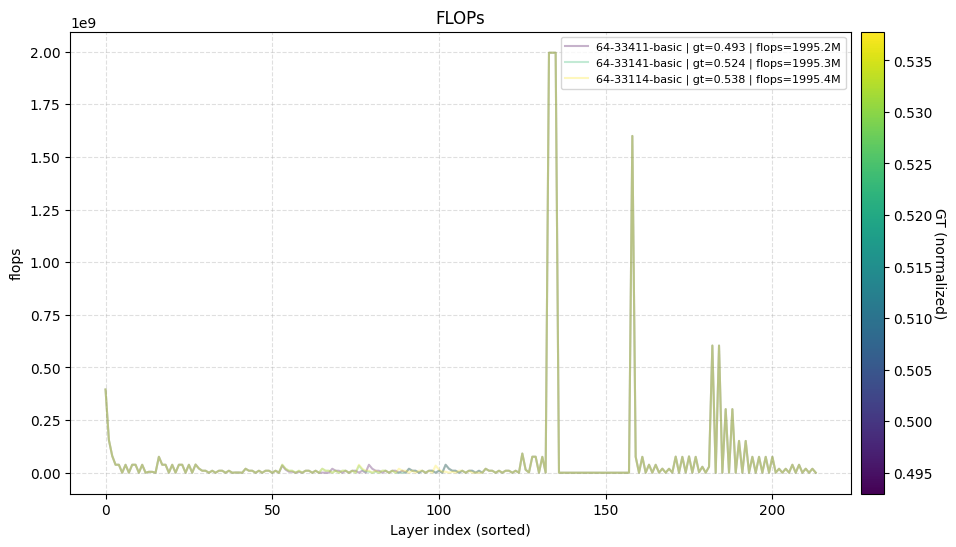

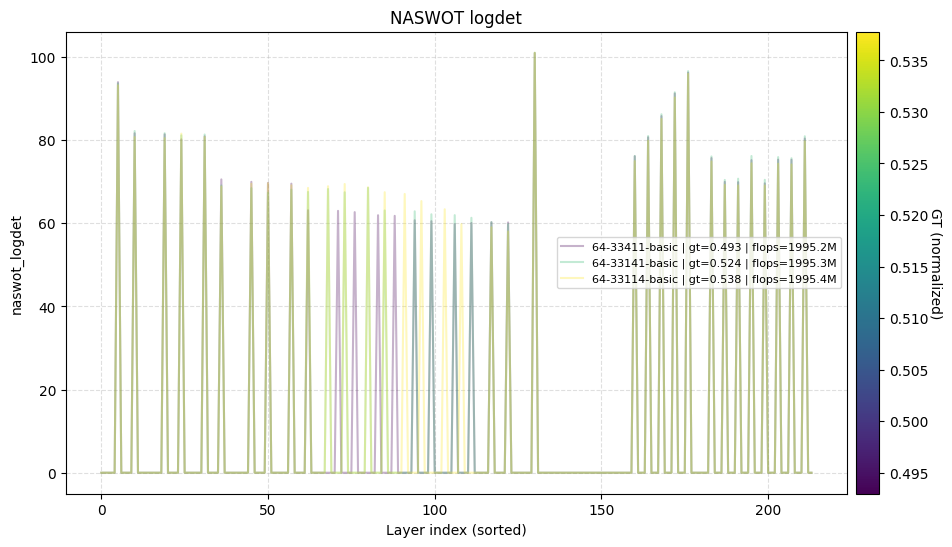

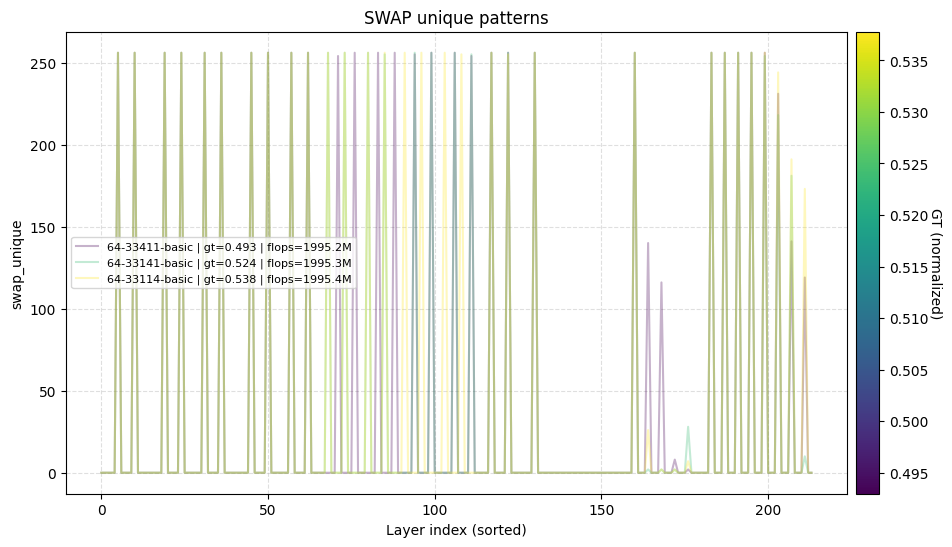

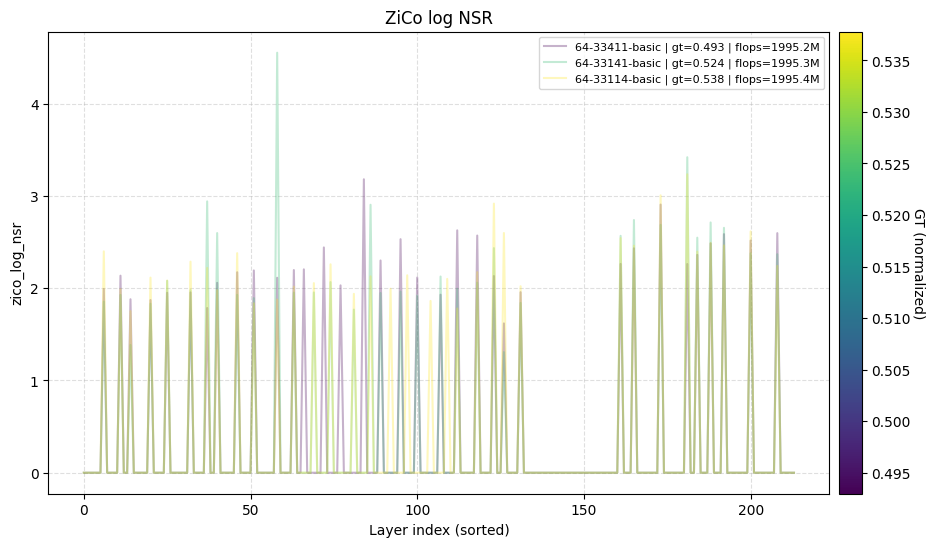

In [16]:
# 可视化：四张图，每张对应一个 proxy，包含多架构曲线
import matplotlib.cm as cm
import matplotlib.colors as mcolors

proxies = [
    ("flops", "FLOPs"),
    ("naswot_logdet", "NASWOT logdet"),
    ("swap_unique", "SWAP unique patterns"),
    ("zico_log_nsr", "ZiCo log NSR"),
]

gts = [r["gt"] for r in results]
flps = [r["flops"] for r in results]
norm_gt = mcolors.Normalize(vmin=min(gts), vmax=max(gts))
norm_fp = mcolors.Normalize(vmin=min(flps), vmax=max(flps))
cmap = cm.get_cmap("viridis")

for col, title in proxies:
    plt.figure(figsize=(12, 6))
    for r in results:
        merged = r["merged"].reset_index(drop=True)
        x = np.arange(len(merged))
        vals = merged[col].to_numpy()
        y = vals.astype(float)
        # y[vals == 0] = np.nan  # 0 不连线
        color = cmap(norm_gt(r["gt"]))
        # alpha = 0.5 + 0.5 * norm_fp(r["flops"])  # FLOPs 越大越不透明
        alpha = 0.3
        label = f"{r['arch_str']} | gt={r['gt']:.3f} | flops={r['flops']/1e6:.1f}M"
        plt.plot(x, y, color=color, alpha=alpha, label=label)
    plt.title(title)
    plt.xlabel("Layer index (sorted)")
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=8, loc="best")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm_gt)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)  # 关键：指定 ax
    cbar.set_label("GT (normalized)", rotation=270, labelpad=10)
    plt.show()


In [ ]:
summary = []
for r in results:
    m = r["merged"]
    summary.append({
        "arch_str": r["arch_str"],
        "gt": float(r["gt"]),
        "flops": float(r["flops"]),
        "num_layers_with_flops": int((m.flops > 0).sum()),
        "num_layers_with_relu": int((m.naswot_logdet != 0).sum()),
    })
summary

{'arch_str': '64-221113-basic',
 'gt': 0.748816967010498,
 'num_layers_with_flops': 176,
 'num_layers_with_relu': 38}